# Data analysis

All the data analysed here was generated using the scripts in this repository.


In [148]:
import glob
import os
from warnings import catch_warnings, simplefilter

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_venn import venn3

import numpy as np
import pandas as pd
from tabulate import tabulate

In [2]:
from home import HOME_DIR
RESULTS_DIR = os.path.join(HOME_DIR, 'results')

In [3]:
class Data:
    def __init__(self, csv_path: str):
        self.df = pd.read_csv(csv_path)
        self.name = os.path.split(csv_path)[-1][:-4]

        with open(csv_path + '.tag', 'r') as f:
            r = [i.replace('\n', '') for i in f.readlines()]

        self.arch, self.mp, self.cell, *_ = r
        if self.cell == 'True':
            self.cell = True
        elif self.cell == 'False':
            self.cell = False
        else:
            raise Exception()


def is_diagonal(arr):
    if isinstance(arr, str):
        arr = np.array(arr.split()).astype(int)

    try:
        if len(arr) == 3:
            return True
    except TypeError:
        if np.isnan(arr):
            return True
        else:
            raise
            
    arr = arr.reshape((3, 3))
        
    return np.allclose(arr - (np.diag(arr) * np.eye(3)), 0)


def get_specific_data(data: list[Data], arch: str, model_path: str, cell: str) -> Data:
    for d in data:
        if d.arch == arch and d.mp == model_path and d.cell == cell:
            return d

In [149]:
class ignore(catch_warnings):
    def __enter__(self):
        super().__enter__()
        simplefilter('ignore')

In [61]:
def plot_column_pie(df: pd.DataFrame, ax, column: str, show_total=False):
    opt = df[column].dropna().value_counts()
    labels = list(opt.index)
    values = opt.values

    total = values.sum()
    fmt = (lambda x: f'{x:.2f}%\n({total*x/100:.0f})') if show_total else '%1.1f%%'

    ax.pie(values, labels=labels, autopct=fmt)


def plot_basic_bar(series):
    fig, ax = plt.subplots()
    
    opt = series.dropna().value_counts()
    labels = list(opt.index)
    values = opt.values
    
    ax.bar(labels, values)
    
    plt.show()


def get_displacements(n: int, bar_width: float = 0.9):
    width = bar_width / n
    half = 0.5 * bar_width
    return width, np.linspace(- (half - 0.5 * width), half - 0.5 * width, n)

In [142]:
def value_counts(series):
    return series.value_counts()


def create_range_counts(ranges, convert_to_float=True):
    def range_counts(series):
        series = series.astype(float) if convert_to_float else series
        return series.groupby(pd.cut(series, ranges), observed=True).count()
    return range_counts


def select_equal(df, name, label):
    return df[name] == label


def select_interval(df, name, label):
    return rdf[name].between(label.left, label.right)


def plot_nested_pie(df, 
                    ax, 
                    primary_column, 
                    secondary_column, 
                    primary_func=value_counts, 
                    secondary_func=value_counts, 
                    select_func=select_equal,
                    size=0.3):
    rdf = df[df[primary_column].notna()]
    
    opt = primary_func(rdf[primary_column])
    labels = list(opt.index)
    values = opt.values

    possible_hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']
     
    n_major_colours = len(labels)
    new_labels = list(secondary_func(rdf[secondary_column]).index)
    n_minor_colours = len(new_labels)
    
    tab10 = plt.color_sequences["tab10"]
    colour_pool = [tab10[i] for i in range(n_major_colours, n_major_colours + n_minor_colours)]
       
    wedges, *_ = ax.pie(values, radius=1, labels=labels, autopct='%1.1f%%', pctdistance=0.85, 
                        #hatch=possible_hatches[:n_major_colours],
                        wedgeprops=dict(width=size, edgecolor='w'))

    counts = []
    colours, edge_colours = [], []
    hatches = []
    for i, label in enumerate(labels):
        sub_df = rdf[select_func(rdf, primary_column, label)]
        vals = list(secondary_func(sub_df[secondary_column]).values)
        
        counts.extend(vals)
        colours.extend(colour_pool[:len(vals)])
        hatches.extend([possible_hatches[i]] * len(vals))
        edge_colours.extend([tab10[i]] * len(vals))
    
    wedges, *_ = ax.pie(counts, radius=1-size, colors=colours, #hatch=hatches,
                        wedgeprops=dict(width=size, edgecolor='w'))

    j = 0
    for wedge, ec in zip(wedges, edge_colours):
        wedge.set(ec=ec)
    
    legend_elements = [Patch(facecolor=c, edgecolor=c, label=lab) for c, lab in zip(colour_pool, new_labels)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 0.5))


def plot_nested_histogram(df, ax, primary_column, secondary_column):
    rdf = df[df[primary_column].notna()]
    
    opt = rdf[primary_column].value_counts()
    labels = opt.index.array
    
    secondary_labels = df[secondary_column].dropna().value_counts().index
    n_slabel = len(secondary_labels)
    
    subdata = []
    for label in labels:
        sub_df = rdf[rdf[primary_column] == label]
        vals = sub_df[secondary_column].dropna().value_counts()
    
        if len(vals) == n_slabel:
            subdata.append(list(vals.values))
        else:
            new_vals = [vals[l] if l in vals.index else 0 for l in secondary_labels]
            subdata.append(new_vals)
    
    subdata = np.array(subdata).T
    width, displacements = get_displacements(n_slabel)
    
    for label, values, disp in zip(secondary_labels, subdata, displacements):
        ax.bar(labels + disp, values, width=width, label=label)
    
    ax.legend()
    
    ax.set_xlabel(primary_column)

## Load all data

Multiple different architectures have been used and with two different conditions - where the cell parameters were and were not optimised.
However, not all architectures were run with all files (yet):

In [5]:
csv_files = glob.glob(os.path.join(RESULTS_DIR, '*.csv'))

In [47]:
data = [Data(path) for path in sorted(csv_files)]
print(tabulate([[d.name, d.arch, d.mp, d.cell == 'cell', d.df.shape[0]] for d in data],
               headers=['name', 'arch', 'model path', 'cell', 'number of structures']))

name                   arch     model path    cell      number of structures
---------------------  -------  ------------  ------  ----------------------
mace_mp_large_no_cell  mace_mp  large         False                      282


### Full dataset

First, we take a look at the full, final dataset:

In [48]:
mace_main = get_specific_data(data, 'mace_mp', 'large', False)

valid_structures = mace_main.df[mace_main.df['optimisation'].notna()]
valid_structures

,compound,id,instrument,method,temperature,optimisation,supercell,imaginary_modes,score,which,is_organic,is_inorganic,is_organometallic,is_polymeric,formula,n_rings,n_aromatic_rings,n_fused_rings
0,acenapthene_1867647,1867647,TFXA,?,?,success,2 0 0 0 2 0 0 0 3,WEIRD-OK,0.181998,organic,True,False,False,False,C24 H20,6,4,6
1,acetanilide_614360,614360,TFXA,?,?,success,2 0 0 0 1 0 0 0 2,FAILED,NaN,organic,True,False,False,False,C8 H9 N1 O1,1,1,0
2,acetic acid_251389,251389,TOSCA,?,?,success,2 2 2,ACCEPTABLE,0.312290,organic,True,False,False,False,C2 H4 O2,0,0,0
4,acetonitrile_114872,114872,TFXA,?,?,spacegroup_changed,NaN,NaN,NaN,organic,True,False,False,False,C2 H3 N1,0,0,0
6,N-Acetyl-p-aminophenol _129925,129925,TOSCA,?,?,success,2 2 2,ACCEPTABLE,0.213293,organic,True,False,False,False,C8 H9 N1 O2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,urea_1278498,1278498,TFXA,neutron,12,success,3 0 0 0 4 0 0 0 4,FAILED,NaN,organic,True,False,False,False,C1 H4 N2 O1,0,0,0
278,uridine_1109253,1109253,TFXA,x-ray,?,success,3 0 0 0 1 0 0 0 1,ACCEPTABLE,0.677771,organic,True,False,False,False,C18 H24 N4 O12,4,0,0
279,m_xylene_183060,183060,TOSCA,x-ray,200,success,2 0 0 0 1 0 0 0 2,FAILED,NaN,organic,True,False,False,False,C8 H10,1,1,0
280,o_xylene_1542585,1542585,TOSCA,x-ray,169,success,2 2 2,ACCEPTABLE,0.295421,organic,True,False,False,False,C8 H10,1,1,0


#### Composition by system type

As can be seen in the plots below, this dataset is strongly dominated by organic molecules due to the fact that the 
automated structure retrieval (`scrape_structures.py`) only has access to the CSD which only contains organic and 
organometallic compounds. It might potentially be possible that the ISIS INS database itself may lean towards 
organic compounds, but such data analysis is more difficult and has not been performed yet.

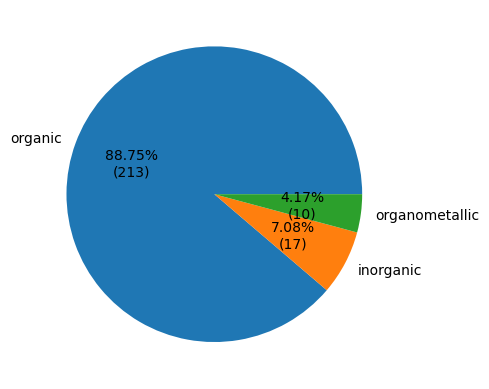

In [49]:
fig, ax = plt.subplots()

plot_column_pie(valid_structures, ax, 'which', True)

plt.show()

This first plot above shows the mutually exclusive composition where a molecule:

- is **organic** if it is in the CSD database and the CSD `is_organometallic` property is `False`
- is **inorganic** if it is NOT in the CSD database and when the CIF file is loaded onto the CSD Python package,
  the `is_organometallic` property is `False`
- is **organometallic** if CSD Python packages `is_organometallic` property is `True`

It is interesting that despite the only source of inorganic molecules being their manual addition, the data 
contains more inorganic systems than organometallic ones, which ARE present in the CSD database. This could be
due to the CSD Python package not being great at identifying organometallic systems, so we have a bit of a 
closer look:

In [50]:
valid_structures[valid_structures['which'] == 'organometallic']['compound']

14              aluminium_trihydride_1681354
59        barium_rhenium_nonahydride_1636109
76        butadiene_iron_tricarbonyl_1116088
85          calcium_aluminum_hydride_1672880
97             chromium_hexacarbonyl_1591947
100              copper_(II)_hydroxide_68459
101    Copper sulfate(VI) pentahydrate_20657
149                        ferrocene_1154880
181            manganese_borohydride_1448927
236                      ruthenocene_1962544
Name: compound, dtype: object

clearly, a lot of these are NOT organometallic, and another several are somewhat on the line. Indeed, the package
is not very good at determining organometallic compounds, though so far it seems to be more in the business
of overestimating them, which makes it all the more unusual that there is so few organometallic compounds.

valid_structures[valid_structures['which'] == 'inorganic']['compound']

the inorganic compounds, on the other hand, seem to be very much in order, and their number is likely consistent
with the fact that the majority of them had to be retrieved by hand

In [52]:
valid_structures[valid_structures['which'] == 'organic']['compound'].iloc[40:60]

81              butan_2_one_2264903
82           but_3_en_2_one_1418572
84                      c70_1297636
88              caprolactam_1913424
89           carbamazapine_i_635853
90        carbamazapine_iii_1027347
91                carbazole_1953805
92           carbon_dioxide_1431769
93         carbon_disulfide_1428424
94     carbon_tetrachloride_1120376
95            chlorobenzene_1050587
96         choline_chloride_1937745
98                 chromone_1415399
99             cinchonidine_1125799
102                coronene_1409823
103            croconic_acid_969904
104               15_crown_5_654895
105              18_crown_6_1915344
106             cyclodecane_1106446
108      1,4_cyclohexadiene_1278701
Name: compound, dtype: object

The organic compound also appear to largely be indeed organic, though there are some clearly inorganic ones
such as carbon dioxide or carbon disulfide. However, given the bluriness of the boundary, it is not straightforward
to write a robust code that can classify a molecule as organic (e.g. carbon tetrachloride above could be considered
either as organic (chloromethane) or inorganic (carbon tetrachloride)). Since CSD Python does not provide a better
out-of-the box solution (and neither do other cheminformatics packages) this will be left as-is.

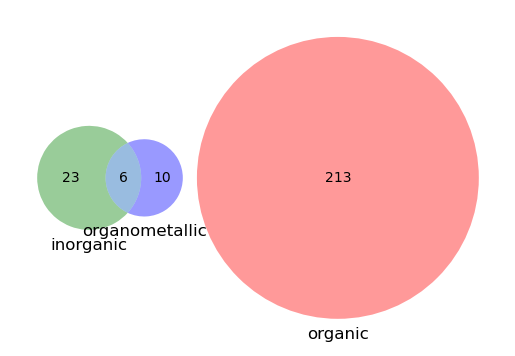

In [41]:
fig, ax = plt.subplots()

organic = valid_structures['is_organic']
inorganic = valid_structures['is_inorganic']
organometallic = valid_structures['is_organometallic']

# venn3({'100': organic.sum(), '010': inorganic.sum(), '001': organometallic.sum(),
#        '110': (organic & inorganic).sum(), '101': (organic & organometallic).sum(), 
#        '001': (inorganic & organometallic).sum()},
#      ('organic', 'inorganic', 'organometallic'))
venn3((organic.sum(), 
       inorganic.sum(), 
       (organic & inorganic).sum(), 
       organometallic.sum(),
       (organic & organometallic).sum(), 
       (inorganic & organometallic).sum(),
       0),
     ('organic', 'inorganic', 'organometallic'))

This plot shows an alternative view of the organic/inorganic/organometallic problem, one that 
is not mutuall exclusive. For this one, simply the `is_organic` and `is_organometallic` methods were 
used to generate the sets


#### Number of rings

This dataset contains a pretty good distribution of compounds with rings in them. As expected, 
there are fewer compounds with larger ring counts, but that should be fairly representative.

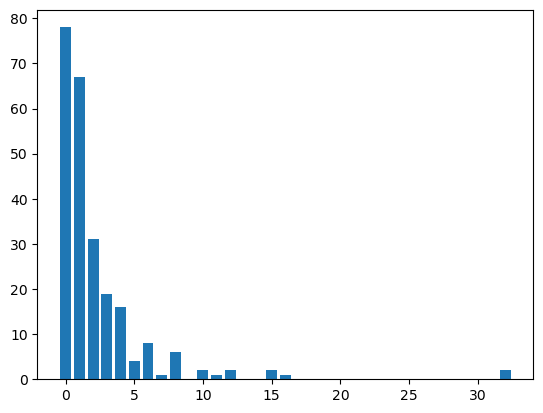

In [13]:
plot_basic_bar(valid_structures['n_rings'])

#### Number of aromatic rings

This is a similar case - there is a good distribution of differently aromatic compounds.

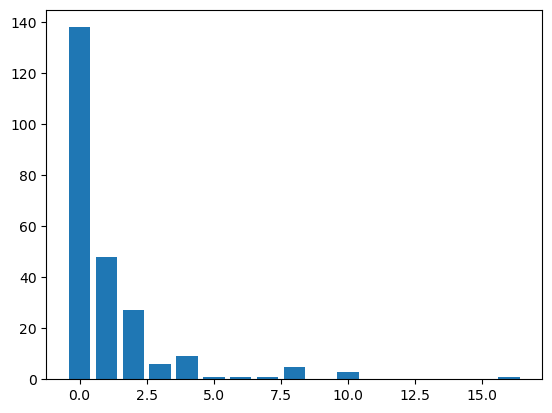

In [14]:
plot_basic_bar(valid_structures['n_aromatic_rings'])

#### Number of fused rings

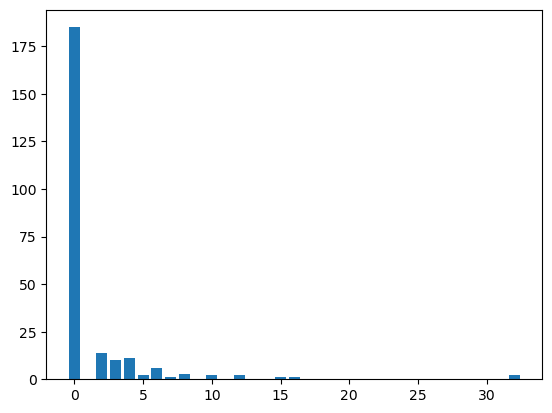

In [15]:
plot_basic_bar(valid_structures['n_fused_rings'])

## Analyse optimisation results

All architectures under all conditions were optimised for up to 2000 steps of the LBFGS ase optimiser and FMAX=1e-6, 
using janus_core.geomopt.GeomOpt.
However, some of the architectures had to be run with a higher FMAX threshold because the default resulted in a large number of
structures not converging at all:

- sevennet -> FMAX=1e-5
- chgnet -> FMAX=1e-4

### Environment

The following environemnt was used in this stage of the pipeline:

```
alignn                   2024.5.27
ase                      3.24.0
chgnet                   0.4.0
e3nn                     0.4.4
janus-core               0.7.1
mace-torch               0.3.10
numpy                    1.26
phonopy                  2.27.0
pytorch-lightning        2.5.0.post0
scikit-learn             1.6.1
scipy                    1.14.1
seekpath                 1.9.7
sevenn                   0.10.4
spglib                   2.5.0
torch                    2.6.0
```

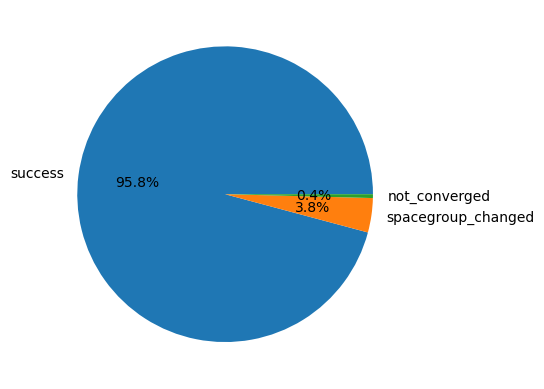

In [62]:
fig, ax = plt.subplots()

plot_column_pie(valid_structures, ax, 'optimisation')

plt.show()

In [63]:
headers = ['run', 'not_converged', 'spacegroup_changed']

contents = []
for d in data:
    not_converged = '\n'.join(d.df[d.df['optimisation'] == 'not_converged']['compound'].values)
    sg_changed = '\n'.join(d.df[d.df['optimisation'] == 'spacegroup_changed']['compound'].values)

    contents.append([d.name, not_converged, sg_changed])

print(tabulate(contents, headers=headers, tablefmt="grid"))

+-----------------------+-----------------+------------------------------+
| run                   | not_converged   | spacegroup_changed           |
+=======================+=================+==============================+
| mace_mp_large_no_cell | c70_1297636     | acetonitrile_114872          |
|                       |                 | benzene_298305               |
|                       |                 | bianthrone_654319            |
|                       |                 | biphenyl_1111366             |
|                       |                 | biphenylene_133648           |
|                       |                 | bipyridine_1111464           |
|                       |                 | hexamethylbenzene_1982454    |
|                       |                 | hexamethylbenzene_1982454    |
|                       |                 | [2,2]_paracyclophane_1036458 |
+-----------------------+-----------------+------------------------------+


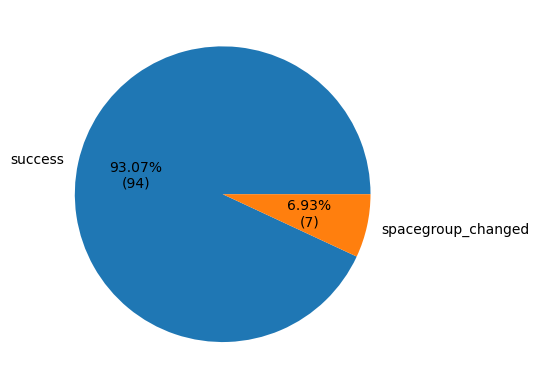

In [68]:
fig, ax = plt.subplots()

plot_column_pie(valid_structures[valid_structures['n_aromatic_rings'] > 0], ax, 'optimisation', True)

plt.show()

## Phonon calculations

All phonon calculations were run with the `run_phonons.py` script, where `fhi-vibes` was used for supercell determination. 
However, the runs that were done on the updated, full list of systems, were run with the `--force-symmetric` option to 
ensure that all the results would be readable by euphonic.

The phonons were then analysed using the `analyse_phonons.py` script with the default imaginary mode tolerance (1e-3).

### Environment

```
ase                      3.23.0
chgnet                   0.4.0
e3nn                     0.4.4
euphonic                 1.3.2
fhi-vibes                1.0.5
janus-core               0.6.6
mace-torch               0.3.8
phonopy                  2.32.0
scikit-learn             1.6.1
scipy                    1.14.1
seekpath                 1.9.7
sevenn                   0.10.4
spglib                   2.3.0
torch                    2.6.0
```

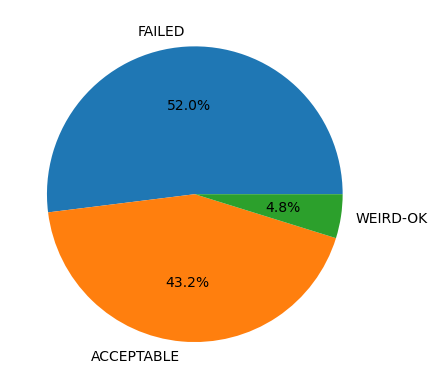

In [83]:
fig, ax = plt.subplots()

plot_column_pie(valid_structures, ax, 'imaginary_modes')

plt.show()

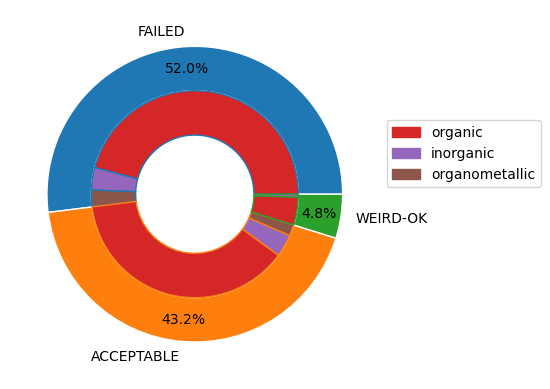

In [71]:
fig, ax = plt.subplots()
plot_nested_pie(valid_structures, ax, 'imaginary_modes', 'which')
plt.show()

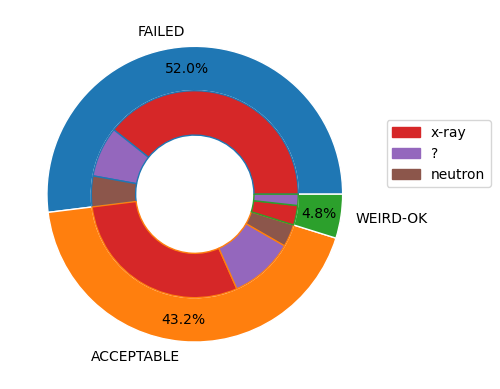

In [73]:
fig, ax = plt.subplots()
plot_nested_pie(valid_structures, ax, 'imaginary_modes', 'method')
plt.show()

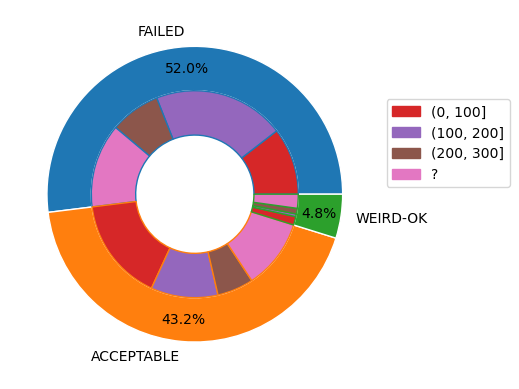

In [132]:
def range_counts(series):
    missing_idx = (series == '?')
    num_series = series[~missing_idx].astype(float)
    
    num_counts = num_series.groupby(pd.cut(num_series, [0, 100, 200, 300]), observed=True).count()
    num_counts['?'] = missing_idx.sum()

    return num_counts

fig, ax = plt.subplots()
plot_nested_pie(valid_structures, ax, 'imaginary_modes', 'temperature', secondary_func=range_counts)
plt.show()

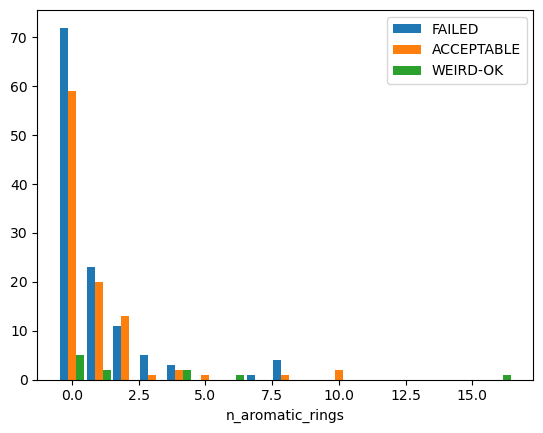

In [88]:
fig, ax = plt.subplots()
plot_nested_histogram(valid_structures, ax, 'n_aromatic_rings', 'imaginary_modes')
plt.show()

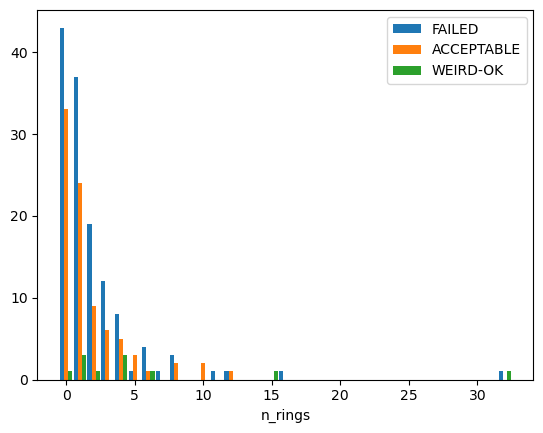

In [89]:
fig, ax = plt.subplots()
plot_nested_histogram(valid_structures, ax, 'n_rings', 'imaginary_modes')
plt.show()

## Comparison with experiment

The compounds were then compared to INS experimental data from the [ISIS INS database](http://wwwisis2.isis.rl.ac.uk/INSdatabase/Theindex.asp)
using the `plot_abins.py` script. For older runs on the original (smaller set of data) only the compounds with TOSCA measurement were
run, while the last runs on the new, larger dataset were run with the `--force-tosca` option to gain data for all compounds, even
if the broadening would be underestimated.

### Environment

```
euphonic            1.3.2
mantid              6.10.20240909.1130
numpy               1.26.4
Pint                0.24.3
scipy               1.14.1
seekpath            2.1.0
spglib              2.5.0
```

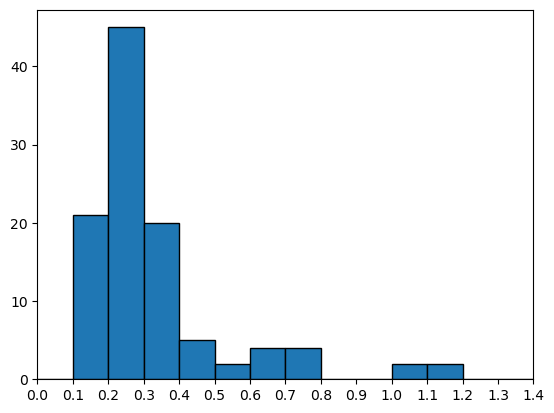

In [130]:
fig, ax = plt.subplots()

ax.hist(valid_structures['score'], np.arange(0, 1.5, 0.1), ec='black')

ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0, 1.5, 0.1))

plt.show()

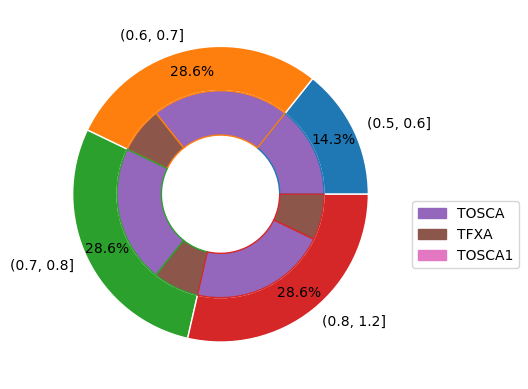

In [150]:
fig, ax = plt.subplots()
high_score_df = valid_structures[(valid_structures['score'] > 0.5) & valid_structures['score'].notna()]

with ignore():
    plot_nested_pie(high_score_df, ax, 'score', 'instrument', create_range_counts([0.5, 0.6, 0.7, 0.8, 1.2]), 
                   select_func=select_interval)
plt.show()

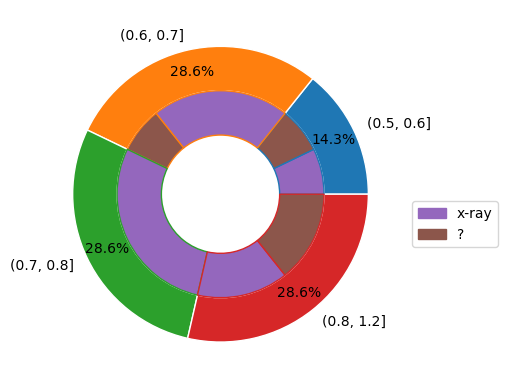

In [152]:
fig, ax = plt.subplots()
high_score_df = valid_structures[(valid_structures['score'] > 0.5) & valid_structures['score'].notna()]

with ignore():
    plot_nested_pie(high_score_df, ax, 'score', 'method', create_range_counts([0.5, 0.6, 0.7, 0.8, 1.2]), 
                   select_func=select_interval)
plt.show()

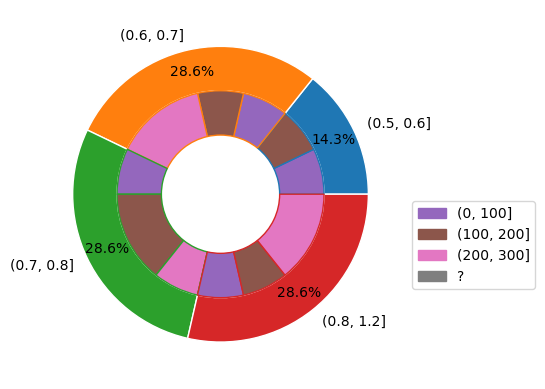

In [153]:
def range_counts(series):
    missing_idx = (series == '?')
    num_series = series[~missing_idx].astype(float)
    
    num_counts = num_series.groupby(pd.cut(num_series, [0, 100, 200, 300]), observed=True).count()
    num_counts['?'] = missing_idx.sum()

    return num_counts


fig, ax = plt.subplots()
high_score_df = valid_structures[(valid_structures['score'] > 0.5) & valid_structures['score'].notna()]

with ignore():
    plot_nested_pie(high_score_df, ax, 'score', 'temperature', create_range_counts([0.5, 0.6, 0.7, 0.8, 1.2]), 
                    secondary_func=range_counts, select_func=select_interval)
plt.show()

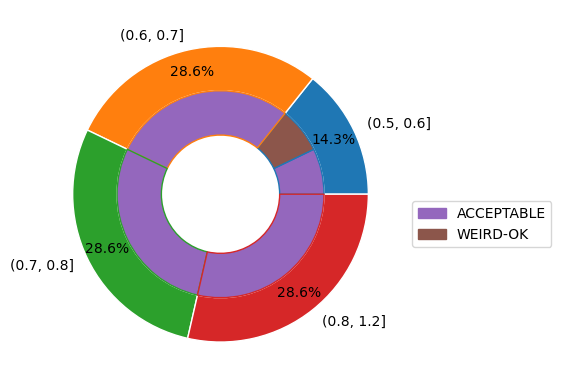

In [154]:
fig, ax = plt.subplots()
high_score_df = valid_structures[(valid_structures['score'] > 0.5) & valid_structures['score'].notna()]

with ignore():
    plot_nested_pie(high_score_df, ax, 'score', 'imaginary_modes', create_range_counts([0.5, 0.6, 0.7, 0.8, 1.2]), 
                   select_func=select_interval)
plt.show()

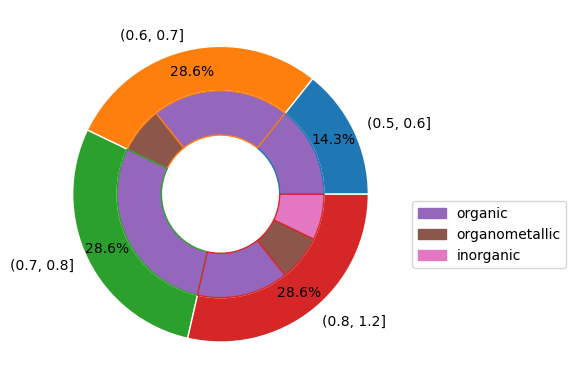

In [155]:
fig, ax = plt.subplots()
high_score_df = valid_structures[(valid_structures['score'] > 0.5) & valid_structures['score'].notna()]

with ignore():
    plot_nested_pie(high_score_df, ax, 'score', 'which', create_range_counts([0.5, 0.6, 0.7, 0.8, 1.2]), 
                   select_func=select_interval)
plt.show()

In [140]:
valid_structures

,compound,id,instrument,method,temperature,optimisation,supercell,imaginary_modes,score,which,is_organic,is_inorganic,is_organometallic,is_polymeric,formula,n_rings,n_aromatic_rings,n_fused_rings
0,acenapthene_1867647,1867647,TFXA,?,?,success,2 0 0 0 2 0 0 0 3,WEIRD-OK,0.181998,organic,True,False,False,False,C24 H20,6,4,6
1,acetanilide_614360,614360,TFXA,?,?,success,2 0 0 0 1 0 0 0 2,FAILED,NaN,organic,True,False,False,False,C8 H9 N1 O1,1,1,0
2,acetic acid_251389,251389,TOSCA,?,?,success,2 2 2,ACCEPTABLE,0.312290,organic,True,False,False,False,C2 H4 O2,0,0,0
4,acetonitrile_114872,114872,TFXA,?,?,spacegroup_changed,NaN,NaN,NaN,organic,True,False,False,False,C2 H3 N1,0,0,0
6,N-Acetyl-p-aminophenol _129925,129925,TOSCA,?,?,success,2 2 2,ACCEPTABLE,0.213293,organic,True,False,False,False,C8 H9 N1 O2,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,urea_1278498,1278498,TFXA,neutron,12,success,3 0 0 0 4 0 0 0 4,FAILED,NaN,organic,True,False,False,False,C1 H4 N2 O1,0,0,0
278,uridine_1109253,1109253,TFXA,x-ray,?,success,3 0 0 0 1 0 0 0 1,ACCEPTABLE,0.677771,organic,True,False,False,False,C18 H24 N4 O12,4,0,0
279,m_xylene_183060,183060,TOSCA,x-ray,200,success,2 0 0 0 1 0 0 0 2,FAILED,NaN,organic,True,False,False,False,C8 H10,1,1,0
280,o_xylene_1542585,1542585,TOSCA,x-ray,169,success,2 2 2,ACCEPTABLE,0.295421,organic,True,False,False,False,C8 H10,1,1,0
